In [24]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import errno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

#!pip install tensorflow


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models



%matplotlib inline
plt.style.use('bmh')



In [25]:
labels_names =['Deer','Human','Unknown']
data_train = np.load('data.npy')
labels_train = np.load('labels.npy')
labels_train = labels_train.astype(int)
class_labels, _ = np.unique(labels_train, return_counts=True)

(270000, 2434) (2434,)


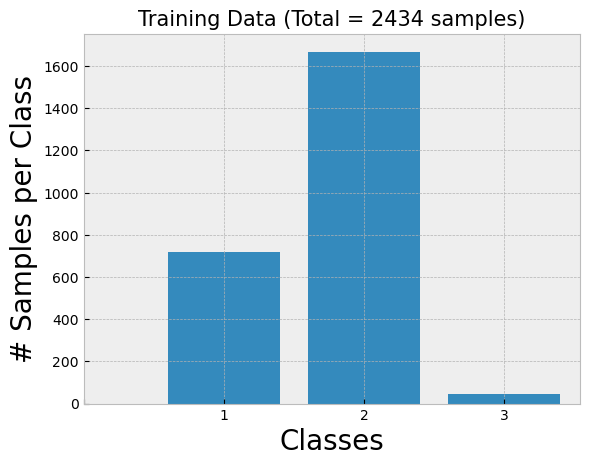

In [26]:

# Loading Data
data_train = np.load('data.npy')
labels_train = np.load('labels.npy')

print(data_train.shape, labels_train.shape)

# Counting number samples per class
vals, counts = np.unique(labels_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(4), ['', '1', '2', '3'])
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(data_train.shape[1])+' samples)',size=15);


In [27]:

#Converting data to directory
transposed_data = data_train.T

for idx, l in np.ndenumerate(labels_train):
   # data = data_train[:,idx]
    data = transposed_data[idx]
    img = Image.fromarray( data.reshape((300,300,3)), 'RGB')
    horz_img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
    labelNr = l - 1
    filename = f'KerasPrep/{labelNr}/{idx[0]}.jpg'
    filename2 = f'KerasPrep/{labelNr}/{idx[0]}flip.jpg'
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    img.save(filename)
    horz_img.save(filename2)

In [33]:
from tensorflow.keras.applications import ResNet50

def build_retrained_model(batch_size, img_height, img_width, data_dir, validation_split,random_rotation,random_zoom,dropout,base_learning_rate):
    # dividing in classes train and validation
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    num_classes = len(train_ds.class_names)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
     #flip the images and rotate and zoom to increase generalization.
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomContrast(0.2),
        layers.RandomRotation(random_rotation),
        layers.RandomZoom(random_zoom),
        layers.Rescaling(1./255),
      ]
    )
    # build model with ResNet50
    model = Sequential([
        data_augmentation,
      ResNet50(include_top=False, weights='imagenet', pooling='max'),
        layers.Flatten(),
      layers.Dense(1028, activation='relu'),
      layers.Dropout(dropout),
      layers.Dense(num_classes)
    ])
    
    return model, train_ds, val_ds

In [30]:
def build_custom_model(batch_size, img_height, img_width, data_dir, validation_split,random_rotation,random_zoom,dropout,dropout2,number_of_layers,batch_normalization,start_neurons):
    # dividing in classes train and validation
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    num_classes = len(train_ds.class_names)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    #flip the images and rotate and zoom to increase generalization.
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomContrast(0.2),
        layers.RandomRotation(random_rotation),
        layers.RandomZoom(random_zoom),
        layers.Rescaling(1./255),
      ]
    )
    # Building the sequential model with relu acitivation function
    
    main_model = []
    
    for layer in range((number_of_layers)):
        main_model += [layers.Conv2D((start_neurons * (2**layer)), 3, padding='same', activation='relu'),
                       layers.MaxPooling2D(2),
                       layers.Dropout(dropout)]
        
        if batch_normalization:
            main_model.append(layers.BatchNormalization())
    
    model = Sequential([
      data_augmentation,
        
        keras.Sequential(main_model),
        
      layers.Flatten(),
      layers.Dense((start_neurons * (2**(number_of_layers-1))), activation='relu'),
      layers.Dropout(dropout2),
      layers.Dense(num_classes)
    ])
    
    # use adam model optimizer.
   
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    """
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=[keras.metrics.TopKCategoricalAccuracy(k=3, name='acc_top3'),
                       keras.metrics.TopKCategoricalAccuracy(k=1, name='acc_top1')])
    """

    model.summary()
    return model, train_ds, val_ds

In [34]:
# Parameters for the Model
batch_size = 32
img_height = 224
img_width = 224
data_dir = 'KerasPrep'
validation_split = 0.2
random_rotation = 0.35
random_zoom = 0.35
dropout = 0.24
epochs=5
base_learning_rate = 0.0001
IMG_SHAPE = (224, 224) + (3,)


# build base model
retrained_model, train_ds, val_ds = build_retrained_model(batch_size, img_height, img_width, data_dir, 
                                             validation_split,random_rotation,random_zoom,
                                             dropout,base_learning_rate)
# use adam model optimizer.
retrained_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
retrained_model.summary()
#train model
history = retrained_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
    
retrained_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

total_epochs =  epochs + 8

history_fine = retrained_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Found 4870 files belonging to 3 classes.
Using 3896 files for training.
Found 4870 files belonging to 3 classes.
Using 974 files for validation.
94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1028)              2106372   
                                                                 
 dropout_2 (Dropout)         (None, 1028)              0         
                                          

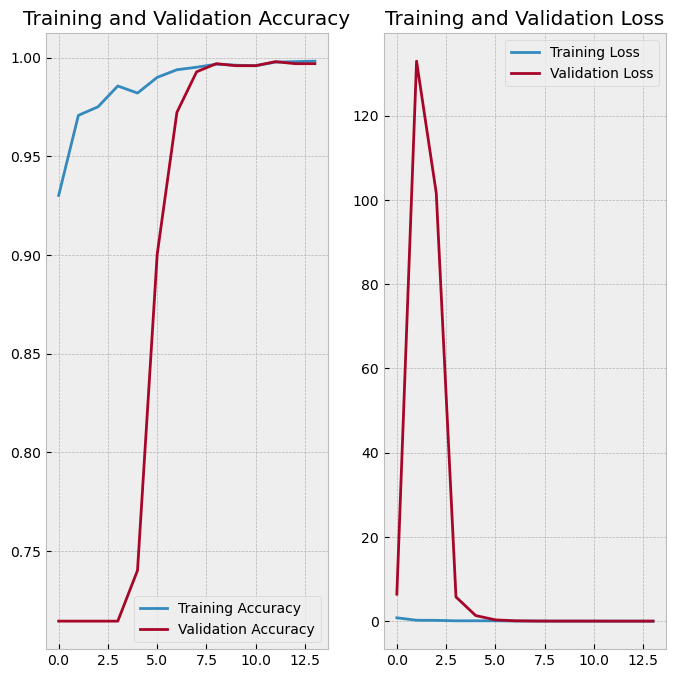

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc_fine = history_fine.history['accuracy']
val_acc_fine = history_fine.history['val_accuracy']

loss_fine = history_fine.history['loss']
val_loss_fine = history_fine.history['val_loss']

epochs_range = range(total_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc + acc_fine, label='Training Accuracy')
plt.plot(epochs_range, val_acc + val_acc_fine, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss + loss_fine, label='Training Loss')
plt.plot(epochs_range, val_loss + val_loss_fine, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
name = 'retrained_model_ResNet50_1.h5'
model = retrained_model.save(name)


In [23]:
from tensorflow.keras import models
import numpy as np
from sklearn.metrics import accuracy_score

# Parameters
img_height = 224
img_width = 224

# Load data
data_test = np.load('data.npy') 
labels_test = np.load('labels.npy')

# Load model
custom_model = models.load_model('retrained_model_ResNet50_1.h5')

# Manually reshaping data into necessary format..
X = data_test.reshape((300,300,3,data_test.shape[1]))
pred_labels=[]
for i in range(data_test.shape[1]):
    # There is likely a better solution then using a for loop
    # But this is the fastest implementation I found that worked
    img = tf.image.resize(X[:,:,:,i], size=[img_height,img_width])
    img1 =tf.expand_dims(img,0)
    
    # Predictions
    predictions = custom_model.predict(img1)
    score = tf.nn.softmax(predictions[0])
    pred_labels += [class_labels[np.argmax(score)]]
    
pred_labels = np.array(pred_labels)
print('Accuracy: ', accuracy_score(labels_test, pred_labels)*100)

1/1 [==============================] - 0s 69ms/step
Accuracy:  98.22753503709811
